In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA


In [2]:
df = pd.read_csv('/kaggle/input/ice-cream-production-over-50-years/ice_cream.csv')

In [3]:
df.head()

,DATE,IPN31152N
0,1972-01-01,59.9622
1,1972-02-01,67.0605
2,1972-03-01,74.2350
3,1972-04-01,78.1120
4,1972-05-01,84.7636


In [13]:
df.describe()

,IPN31152N
count,577.000000
mean,109.701844
std,27.951723
min,58.659800
25%,88.514900
50%,107.461700
75%,127.932300
max,196.173700


In [8]:
df['DATE'].max()

'2020-01-01'

In [9]:
df['DATE'].min()

'1972-01-01'

In [10]:
df.isna().sum()

DATE         0
IPN31152N    0
dtype: int64

In [11]:
df.duplicated().sum()

0

In [35]:
df.shape

(577, 1)

Text(0, 0.5, 'Revenue')

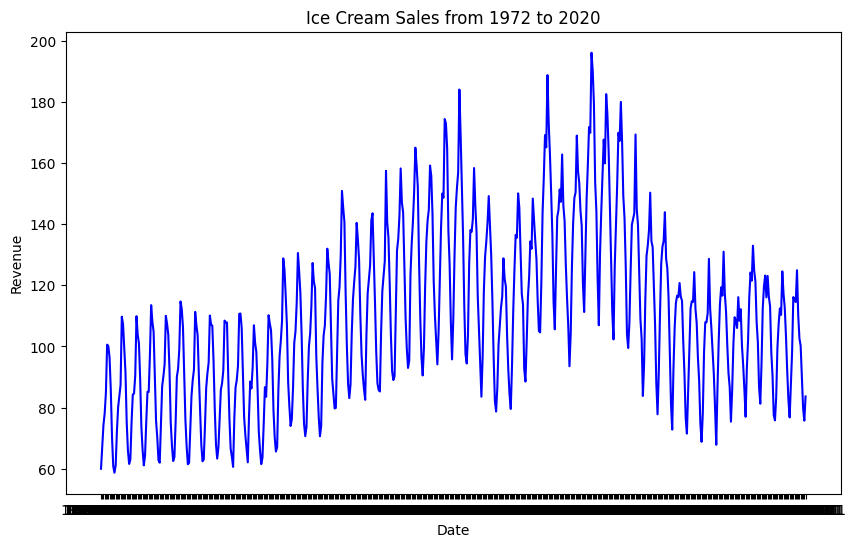

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df['DATE'], df['IPN31152N'], color='blue')
plt.title('Ice Cream Sales from 1972 to 2020')
plt.xlabel('Date')
plt.ylabel('Revenue')

In [16]:
df = df.rename(columns = {'DATE':'date','IPN31152N':'sales'})
df['date'] = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df

,sales
date,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-09-01,100.1741
2019-10-01,90.1684
2019-11-01,79.7223


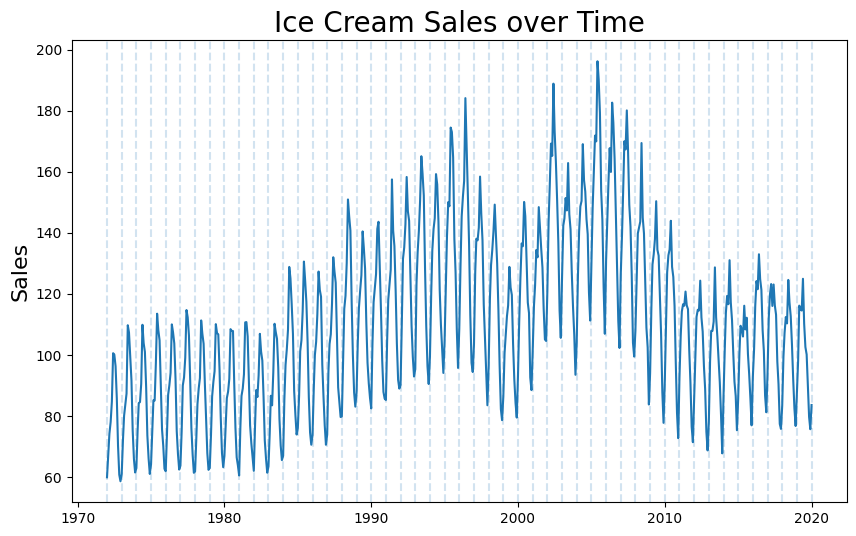

In [21]:
plt.figure(figsize=(10,6))
plt.plot(df.sales)
plt.title('Ice Cream Sales over Time', fontsize=20)
plt.ylabel('Sales', fontsize=16)
for year in range(1972,2021):
    plt.axvline(pd.to_datetime(str(year)),linestyle='--', alpha=0.2)

In [40]:
df_copy = df.copy()
df_copy['Year'] = df.index.year
sales_sum_by_year = df_copy.groupby('Year')['sales'].sum()
# print(sales_sum_by_year)

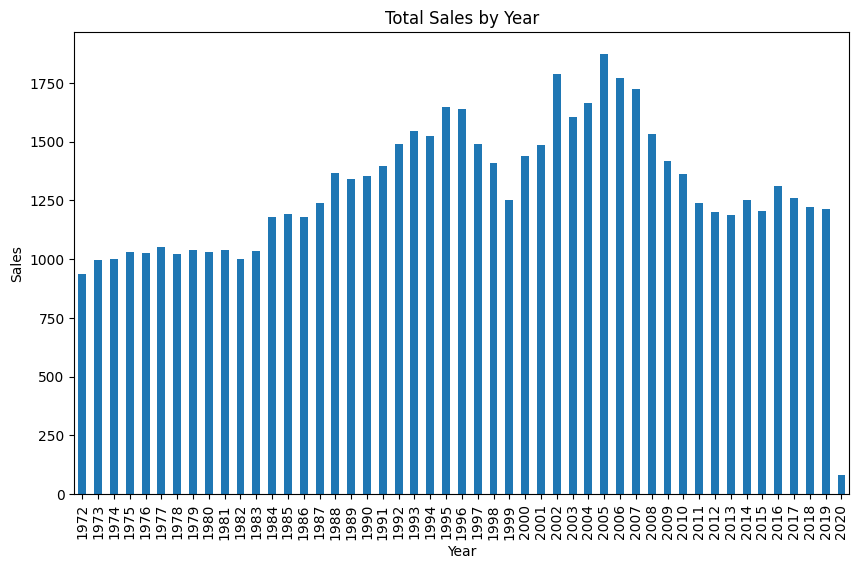

In [50]:
sales_sum_by_year.plot(kind='bar', figsize=(10, 6))
plt.title('Total Sales by Year')
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

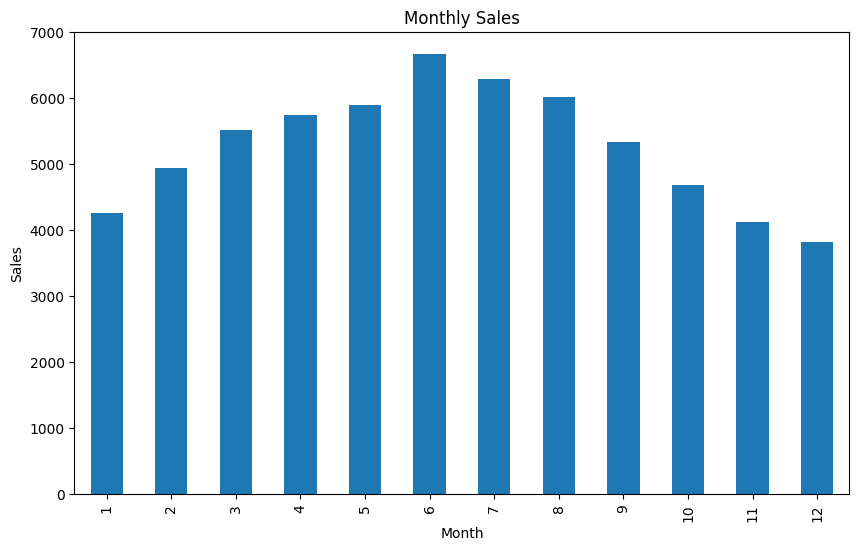

In [48]:
df_copy = df.copy()
df_copy['Month'] = df_copy.index.month
monthly_sales = df_copy.groupby('Month')['sales'].sum()

plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

In [33]:
values = df.values

parts = int(len(values)/3)

part_1, part_2, part_3 = values[0:parts], values[parts:(
	parts*2)], values[(parts*2):(parts*3)]

mean_1, mean_2, mean_3 = part_1.mean(), part_2.mean(), part_3.mean()

var_1, var_2, var_3 = part_1.var(), part_2.var(), part_3.var()

print('mean1=%f, mean2=%f, mean2=%f' % (mean_1, mean_2, mean_3))
print('variance1=%f, variance2=%f, variance2=%f' % (var_1, var_2, var_3))


mean1=88.552894, mean2=123.838215, mean2=116.850220

variance1=328.595535, variance2=592.726918, variance2=720.819144


In [42]:
res = adfuller(values)

print('Augmneted Dickey_fuller Statistic: %f' % res[0])
print('p-value: %f' % res[1])

print('critical values at different levels:')
for k, v in res[4].items():
	print('\t%s: %.3f' % (k, v))


Augmneted Dickey_fuller Statistic: -1.758009

p-value: 0.401499

critical values at different levels:

	1%: -3.442

	5%: -2.867

	10%: -2.570


From the previous graphs and the fact that the mean and variance of the three groups are considerably different from each other,and the ADF test we can see that this data is non-stationary

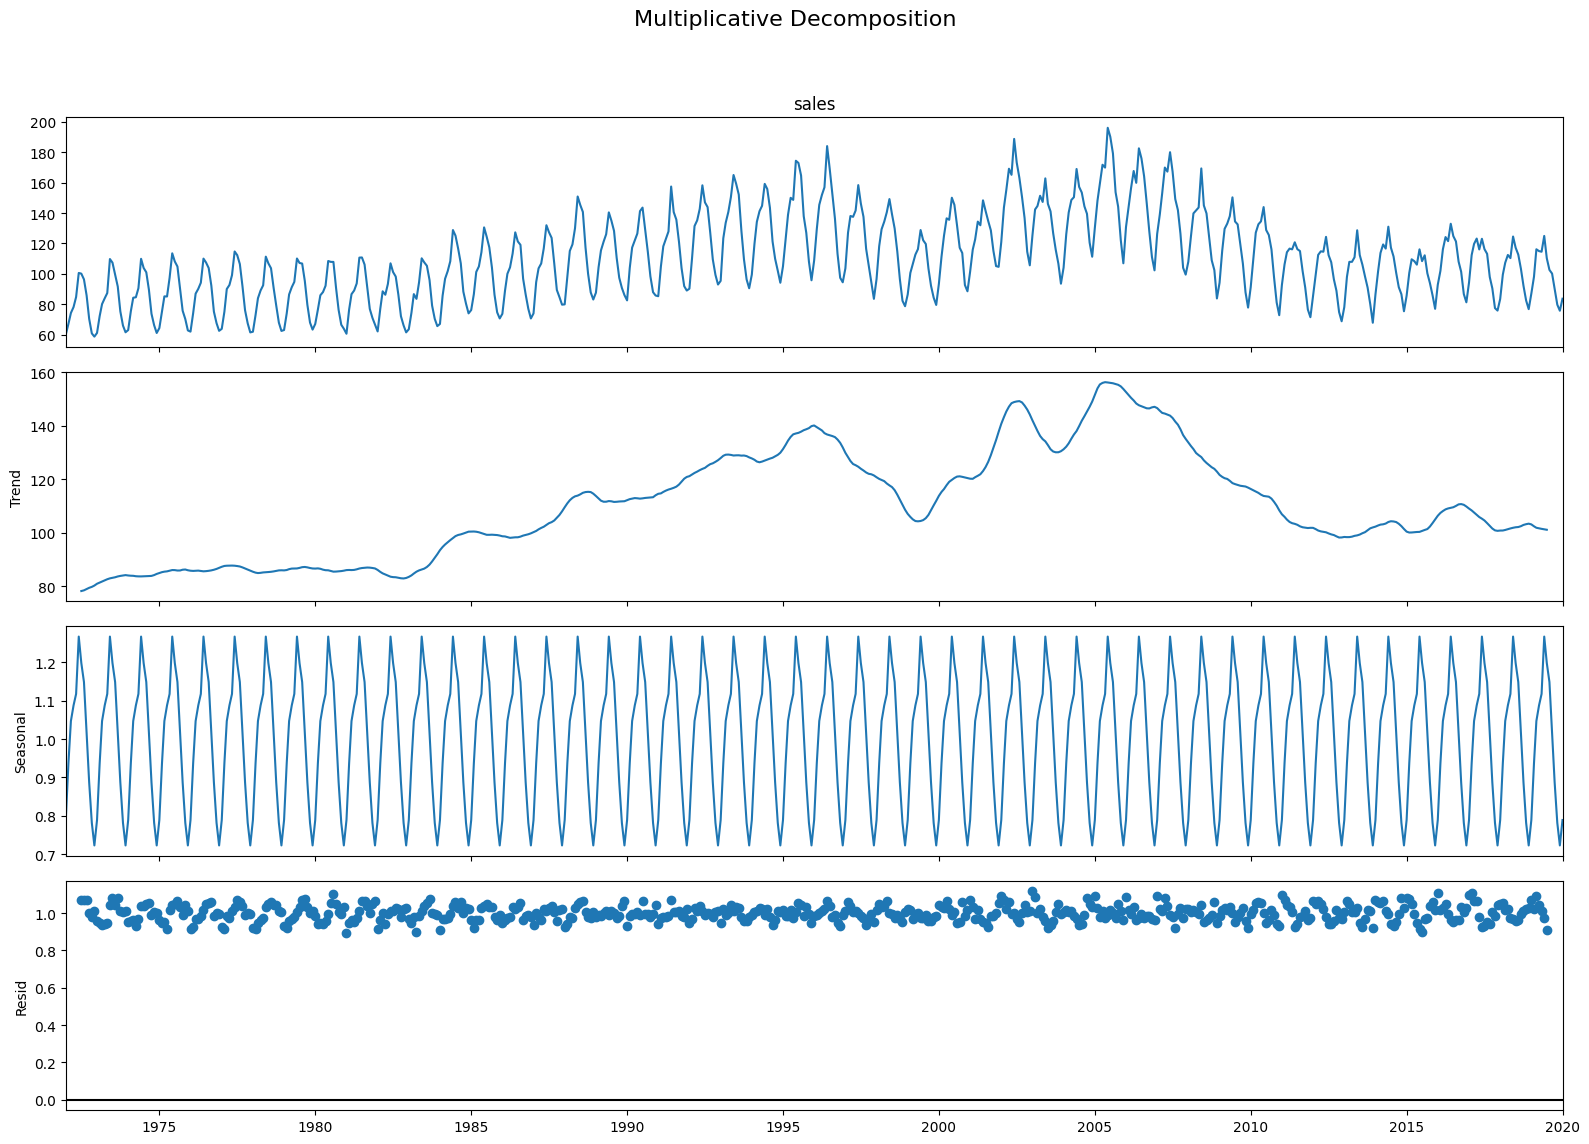

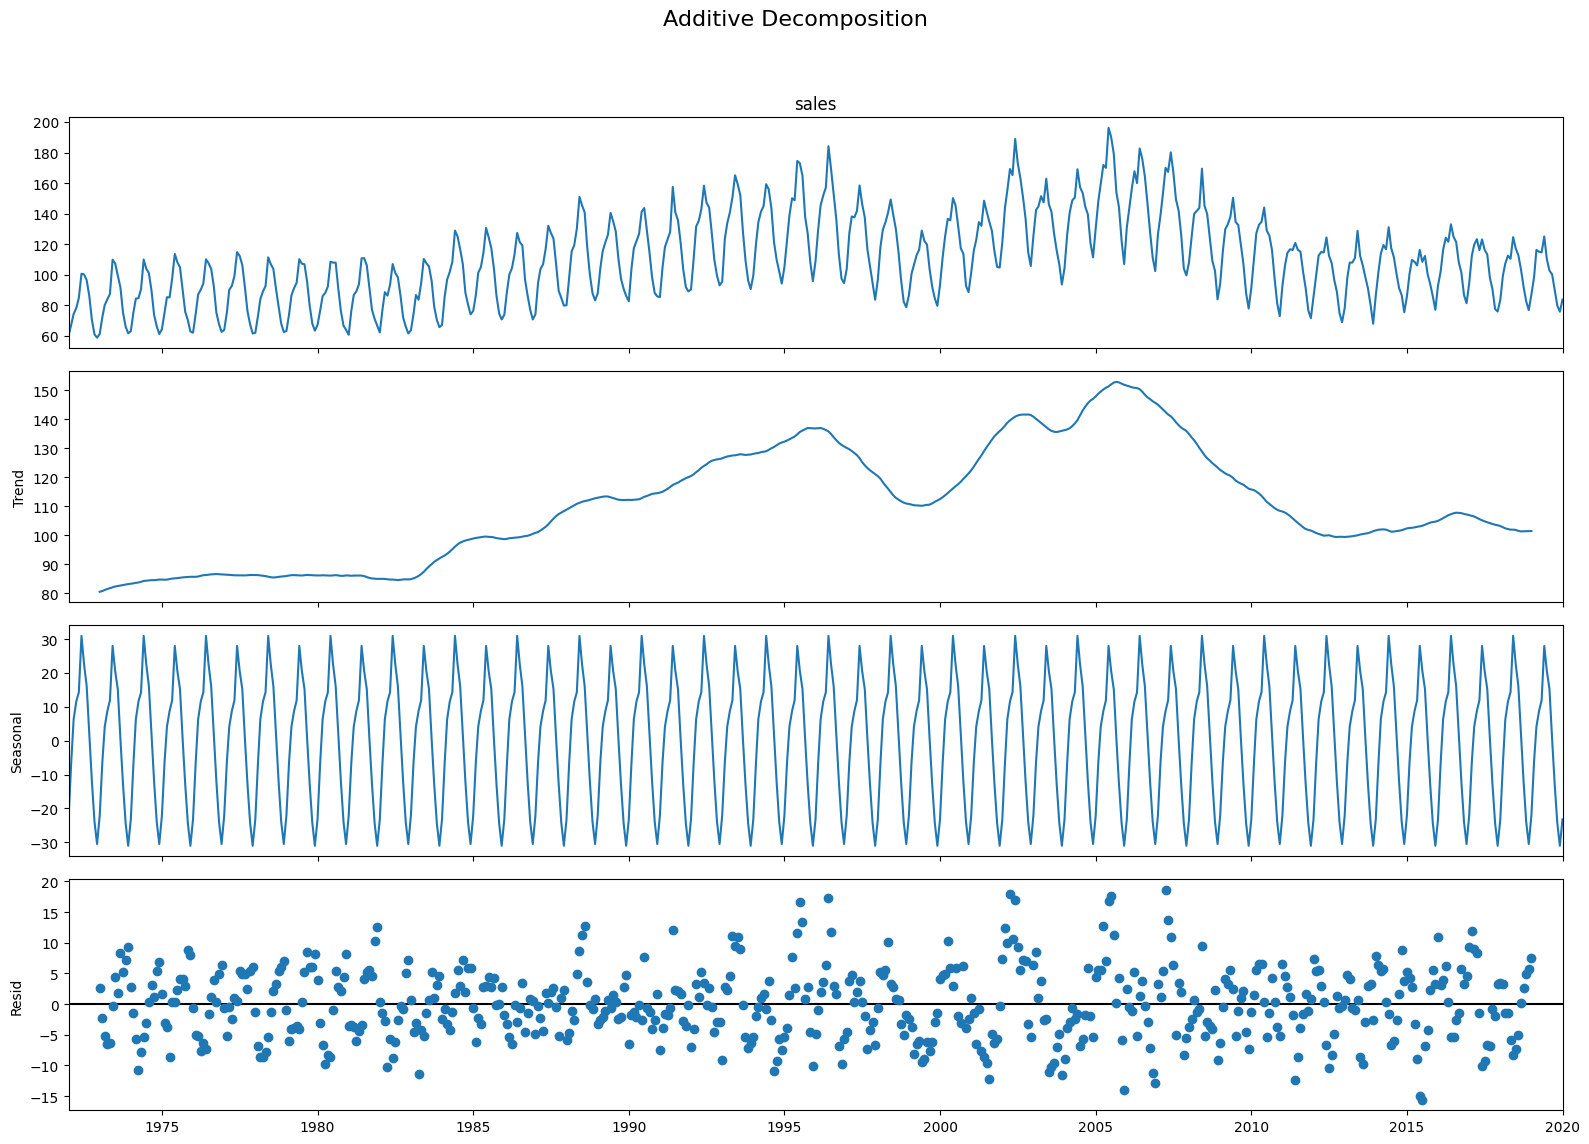

In [111]:
multiplicative_decomposition = seasonal_decompose(df['sales'], model='multiplicative')

additive_decomposition = seasonal_decompose(df['sales'], model='additive',period=24)

# Plot
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

##### The residuals of the multiplicative decomposition has some pattern left over.
##### The additive decomposition, looks quite random which is good. So ideally, additive decomposition should be preferred for this particular series.



## Solving non-stationary

### Detrend

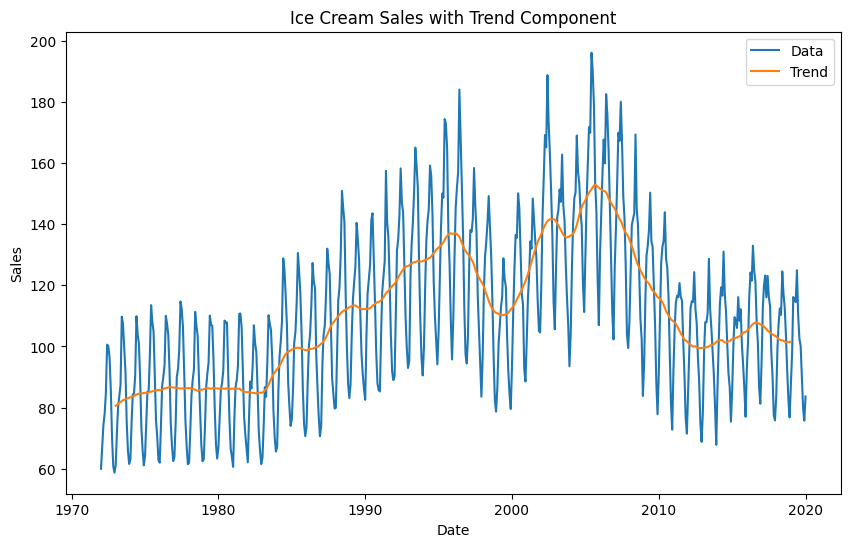

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['sales'], label='Data')
plt.plot(df.index, additive_decomposition.trend, label='Trend')
plt.title('Ice Cream Sales with Trend Component')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Ice Cream Sales detrended by subtracting the trend component')

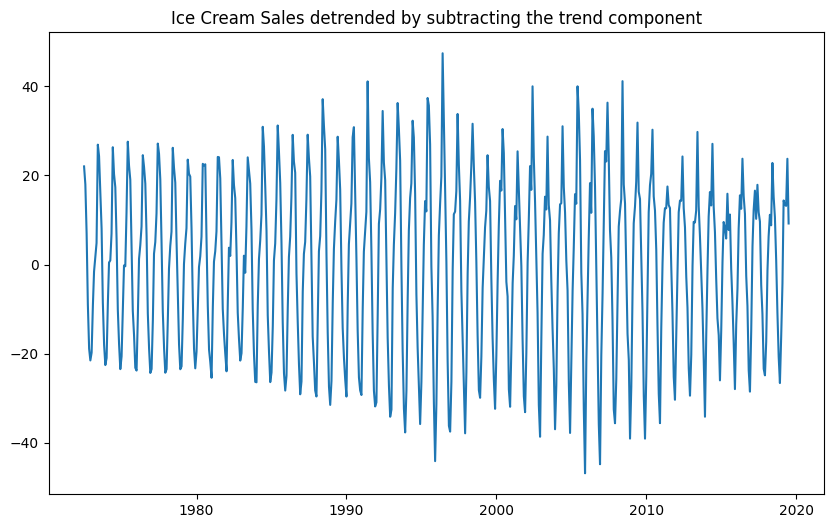

In [113]:
plt.figure(figsize=(10, 6))
result_add = seasonal_decompose(df['sales'], model='additive')
detrended = df['sales'].values - result_add.trend
plt.plot(detrended)
plt.title('Ice Cream Sales detrended by subtracting the trend component')

## Deseasonalize

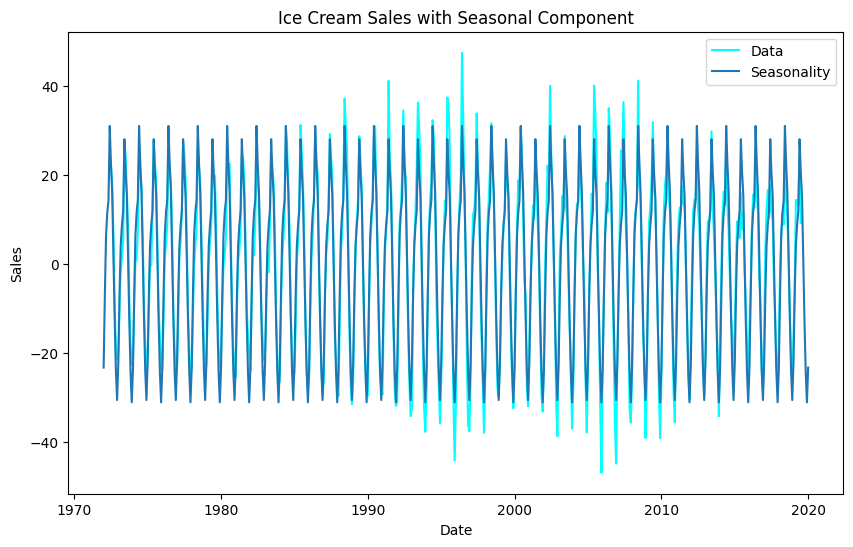

In [114]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, detrended, label='Data', color='cyan')
plt.plot(df.index, additive_decomposition.seasonal, label='Seasonality')
plt.title('Ice Cream Sales with Seasonal Component')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Ice Cream Sales deseasonalized by subtracting the seasonal component')

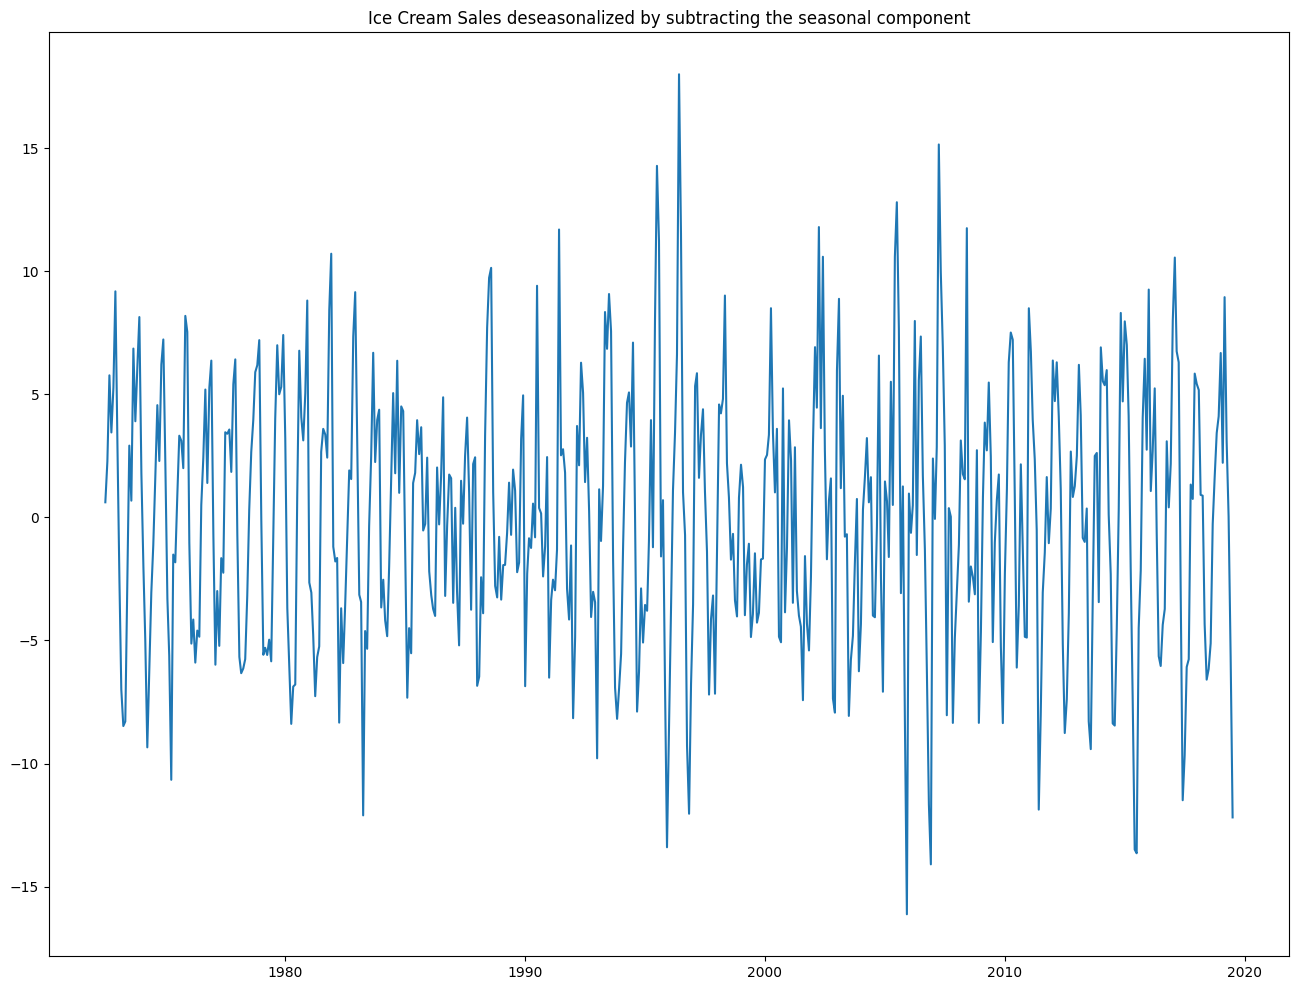

In [115]:
deseasonalized = detrended - result_add.seasonal
plt.plot(deseasonalized)
plt.title('Ice Cream Sales deseasonalized by subtracting the seasonal component')

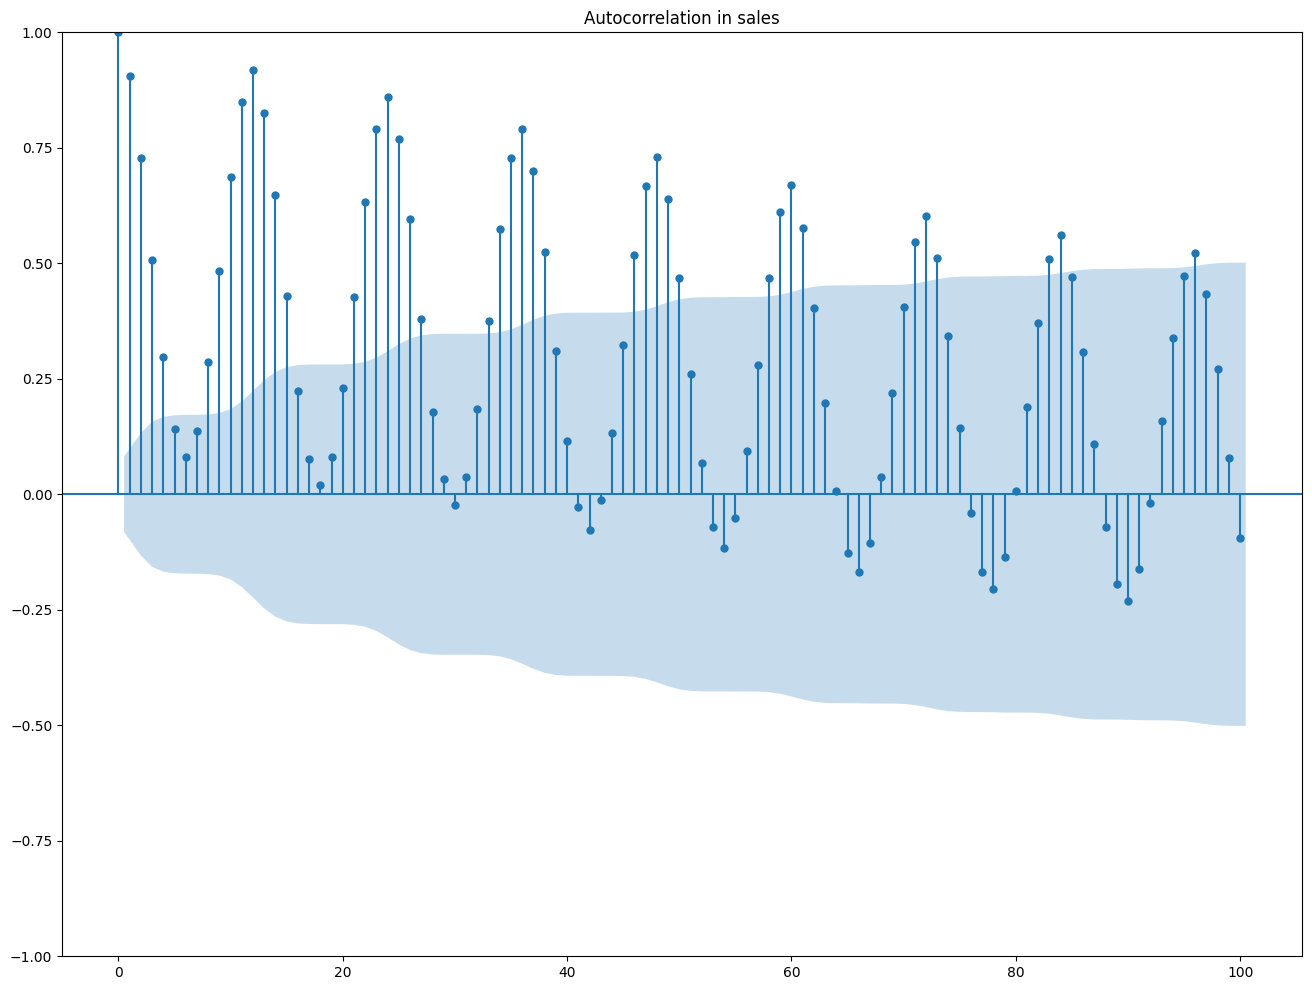

In [126]:
acf_plot = plot_acf(df['sales'], title='Autocorrelation in sales',lags=100)


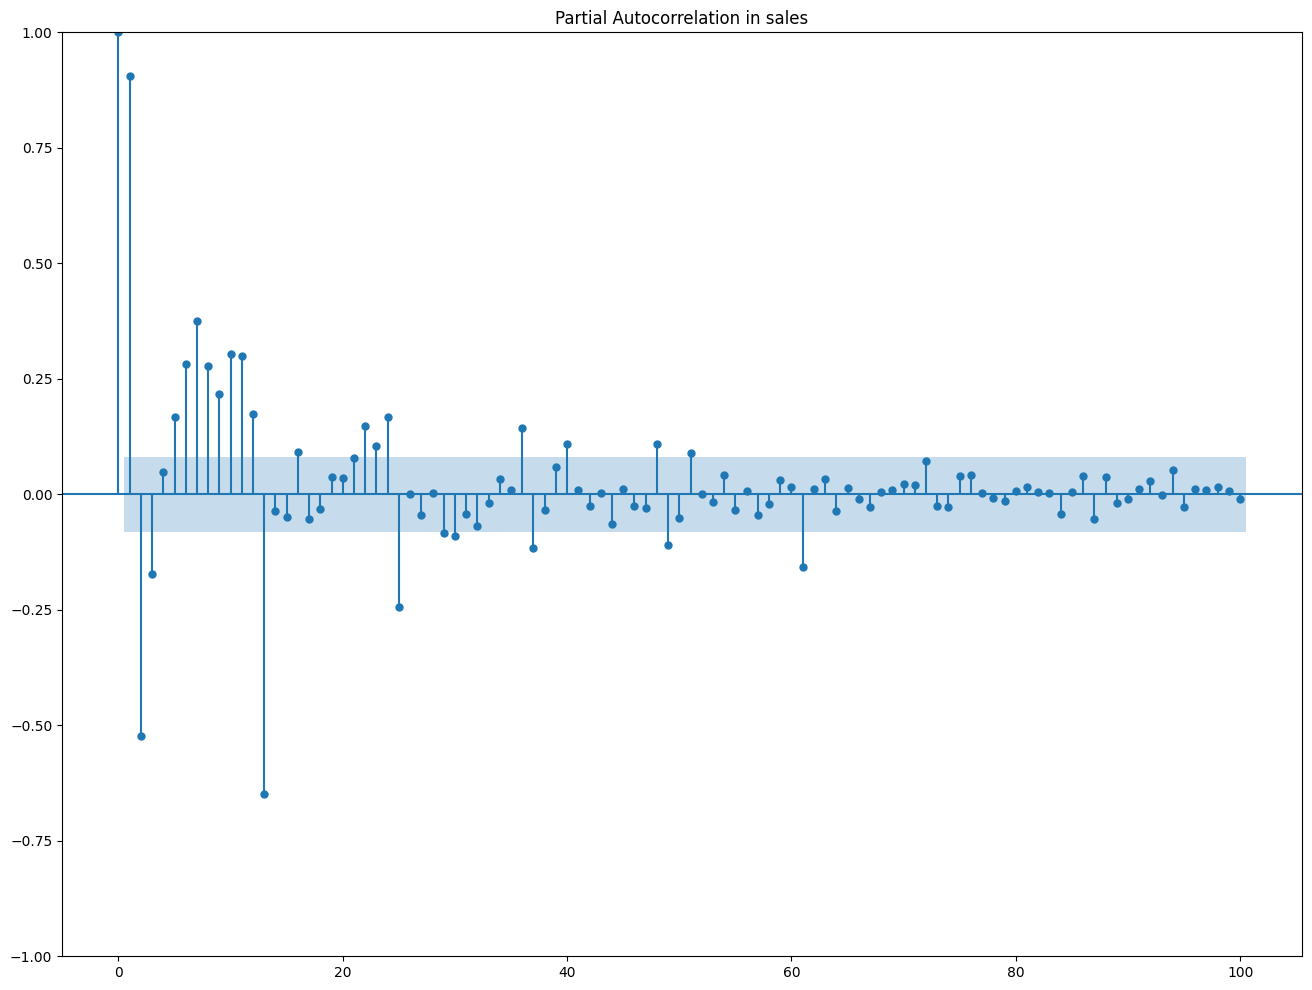

In [127]:
pacf_plot = plot_pacf(df['sales'], title='Partial Autocorrelation in sales',lags=100)


# Model Fitting

In [144]:
train_end = datetime(2007,1,1)
test_end = datetime(2008,1,1)
train_data = deseasonalized[:train_end]
test_data = deseasonalized[train_end + timedelta(days=1):test_end]

In [145]:
model = ARIMA(train_data, order=(15,0,15))

c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.

  self._init_dates(dates, freq)

c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.

  self._init_dates(dates, freq)

c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.

  self._init_dates(dates, freq)


In [146]:
model_fit = model.fit()

c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

  warn('Non-stationary starting autoregressive parameters'

c:\Users\Yara\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

  warnings.warn("Maximum Likelihood optimization failed to "


In [147]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)
residuals = test_data - predictions

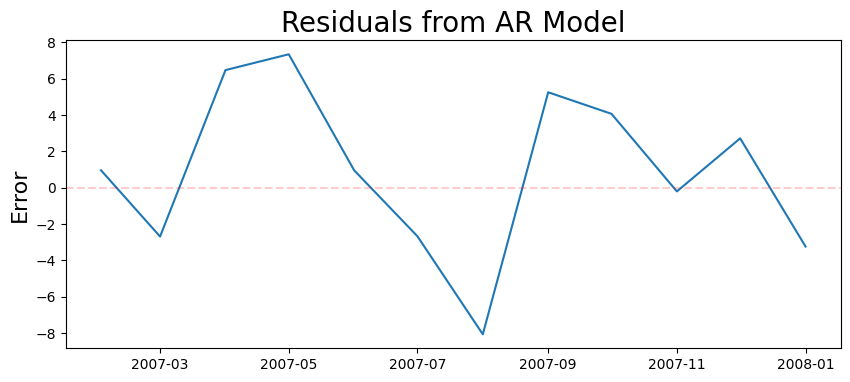

In [148]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0, color='r', linestyle='--', alpha=0.2)

Text(0, 0.5, 'Sales')

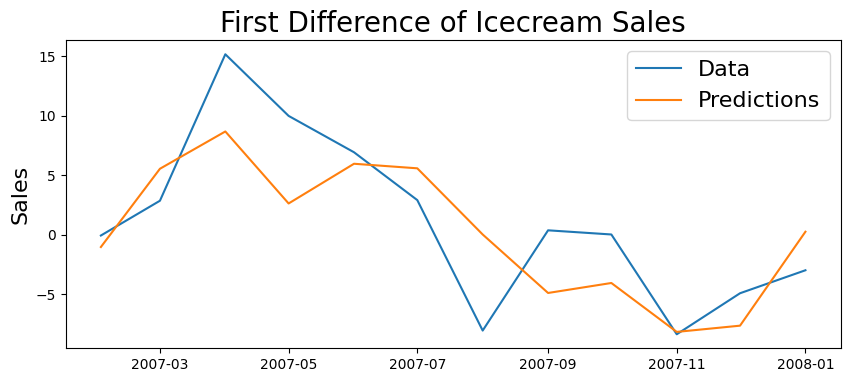

In [149]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('First Difference of Icecream Sales', fontsize=20)
plt.ylabel('Sales', fontsize=16)

In [150]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 4.46652777827841


Text(0, 0.5, 'Production')

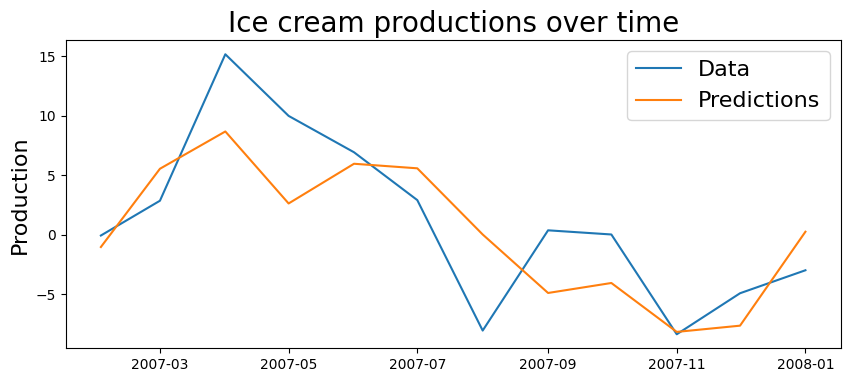

In [151]:
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions)
plt.legend(('Data','Predictions'),fontsize=16)
plt.title('Ice cream productions over time',fontsize=20)
plt.ylabel('Production',fontsize=16)